In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import unicodedata
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import ops
from sklearn.model_selection import train_test_split
from transformers import EarlyStoppingCallback


In [2]:
df = pd.read_csv(
    'fra.txt',
    sep='\t',
    header=None,
    names=['english', 'french', 'meta']
)


# EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177210 entries, 0 to 177209
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   english  177210 non-null  object
 1   french   177210 non-null  object
 2   meta     177210 non-null  object
dtypes: object(3)
memory usage: 4.1+ MB


In [4]:
df.head(5)

,english,french,meta
0,Go.,Va !,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1,Hi.,Salut !,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
2,Hi.,Salut.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
3,Run!,Cours !,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
4,Run!,Courez !,CC-BY 2.0 (France) Attribution: tatoeba.org #9...


In [5]:
df = df[['english','french']]

In [6]:
df

,english,french
0,Go.,Va !
1,Hi.,Salut !
2,Hi.,Salut.
3,Run!,Cours !
4,Run!,Courez !
...,...,...
177205,"Top-down economics never works, said Obama. ""T...","« L'économie en partant du haut vers le bas, ç..."
177206,A carbon footprint is the amount of carbon dio...,Une empreinte carbone est la somme de pollutio...
177207,Death is something that we're often discourage...,La mort est une chose qu'on nous décourage sou...
177208,Since there are usually multiple websites on a...,Puisqu'il y a de multiples sites web sur chaqu...


In [7]:
df.isnull().sum()

,0
english,0
french,0


In [8]:
df.duplicated().sum()

np.int64(0)

In [9]:
df['en_len'] = df['english'].apply(lambda x: len(x.split()))
df['fr_len'] = df['french'].apply(lambda x: len(x.split()))

In [10]:
df[['en_len','fr_len']].describe()

,en_len,fr_len
count,177210.000000,177210.000000
mean,6.158174,6.703363
std,2.486025,2.789052
min,1.000000,1.000000
25%,4.000000,5.000000
50%,6.000000,6.000000
75%,7.000000,8.000000
max,44.000000,55.000000


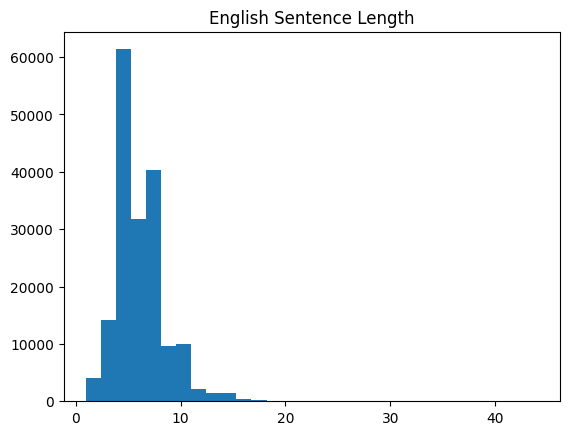

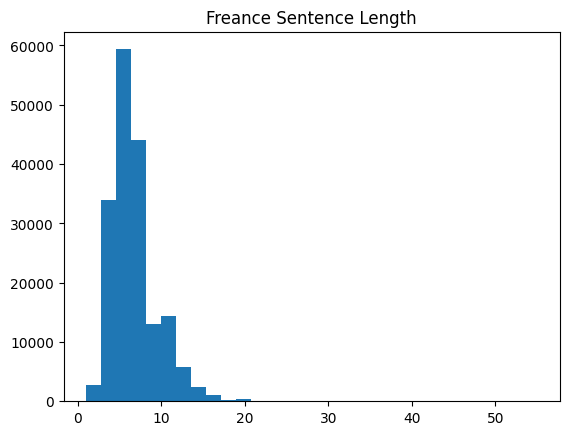

In [11]:
plt.hist(df['en_len'],bins=30)
plt.title("English Sentence Length")
plt.show()

plt.hist(df['fr_len'],bins=30)
plt.title("Freance Sentence Length")
plt.show()

In [12]:
df[df['en_len'] > 20]

,english,french,en_len,fr_len
176797,"I'd like to ask you a question, but if this is...",J'aimerais vous poser une question mais si le ...,21,19
176798,"I'd like to ask you a question, but if this is...",J'aimerais te poser une question mais si le mo...,21,19
176868,I still have a scar on my left leg from a car ...,J'ai encore une cicatrice sur ma jambe gauche ...,22,24
176873,"If you want to lose weight, the best thing to ...","Si vous voulez perdre du poids, la meilleure c...",21,19
176894,As soon as I can get my son to scan our family...,Dès que je parviens à faire scanner nos photos...,21,20
...,...,...,...,...
177205,"Top-down economics never works, said Obama. ""T...","« L'économie en partant du haut vers le bas, ç...",34,47
177206,A carbon footprint is the amount of carbon dio...,Une empreinte carbone est la somme de pollutio...,34,33
177207,Death is something that we're often discourage...,La mort est une chose qu'on nous décourage sou...,37,47
177208,Since there are usually multiple websites on a...,Puisqu'il y a de multiples sites web sur chaqu...,43,49


In [13]:
df[df['fr_len'] > 20]

,english,french,en_len,fr_len
170837,"If there's anything I can do for you, please l...",S'il y a quoi que ce soit que je puisse faire ...,12,21
172554,"What's going on in the cave? I'm curious. ""I h...",« Qu'est-ce qu'il se passe dans la grotte ? Je...,12,23
173020,"What's happening in the cave? I'm curious. ""I ...",« Qu'est-ce qu'il se passe dans la grotte ? Je...,11,23
174466,"If I tell my mother, she'll worry, so I don't ...","Si j'en parle à ma mère, elle va se faire du s...",14,22
174534,The bottom 40% of the U.S. population has only...,Les quarante pour cent de la population des US...,13,23
...,...,...,...,...
177205,"Top-down economics never works, said Obama. ""T...","« L'économie en partant du haut vers le bas, ç...",34,47
177206,A carbon footprint is the amount of carbon dio...,Une empreinte carbone est la somme de pollutio...,34,33
177207,Death is something that we're often discourage...,La mort est une chose qu'on nous décourage sou...,37,47
177208,Since there are usually multiple websites on a...,Puisqu'il y a de multiples sites web sur chaqu...,43,49


In [14]:
df = df[(df.en_len <= 30) & (df.fr_len <= 30)]

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 177193 entries, 0 to 177200
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   english  177193 non-null  object
 1   french   177193 non-null  object
 2   en_len   177193 non-null  int64 
 3   fr_len   177193 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 6.8+ MB


In [16]:
def get_unique_chars(series):
    chars = set()
    for text in series:
        chars.update(text)
    return sorted(chars)

en_chars = get_unique_chars(df['english'])
fr_chars = get_unique_chars(df['french'])

en_chars, fr_chars

([' ',
  '!',
  '"',
  '$',
  '%',
  '&',
  "'",
  '+',
  ',',
  '-',
  '.',
  '/',
  '0',
  '1',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  ':',
  ';',
  '?',
  'A',
  'B',
  'C',
  'D',
  'E',
  'F',
  'G',
  'H',
  'I',
  'J',
  'K',
  'L',
  'M',
  'N',
  'O',
  'P',
  'Q',
  'R',
  'S',
  'T',
  'U',
  'V',
  'W',
  'X',
  'Y',
  'Z',
  'a',
  'b',
  'c',
  'd',
  'e',
  'f',
  'g',
  'h',
  'i',
  'j',
  'k',
  'l',
  'm',
  'n',
  'o',
  'p',
  'q',
  'r',
  's',
  't',
  'u',
  'v',
  'w',
  'x',
  'y',
  'z',
  '\xa0',
  '\xad',
  'º',
  'ç',
  'é',
  'ö',
  'ú',
  '–',
  '‘',
  '’',
  '₂',
  '€'],
 [' ',
  '!',
  '"',
  '$',
  '%',
  '&',
  "'",
  '(',
  ')',
  '+',
  ',',
  '-',
  '.',
  '/',
  '0',
  '1',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  ':',
  ';',
  '?',
  'A',
  'B',
  'C',
  'D',
  'E',
  'F',
  'G',
  'H',
  'I',
  'J',
  'K',
  'L',
  'M',
  'N',
  'O',
  'P',
  'Q',
  'R',
  'S',
  'T',
  'U',
  'V',
  'W',
  'X',
  'Y',
  'Z',

In [17]:
def normalize_text(text):
    text = unicodedata.normalize("NFKC", text)

    text = text.lower().strip()

    text = re.sub(r"[\u00a0\u2009\u200b\u202f]", " ", text)

    text = text.replace("«", '"').replace("»", '"')
    text = text.replace("‘", "'").replace("’", "'")
    text = text.replace("–", "-").replace("—", "-")

    text = text.replace("\xad", "")

    text = re.sub(r"[0-9₂]", " ", text)

    text = re.sub(r"[€$%&+/;:]", " ", text)

    text = re.sub(r"([?.!,\"'])", r" \1 ", text)

    text = re.sub(r"[^a-zà-ÿ\s?.!,\"']", " ", text)

    text = re.sub(r"\s+", " ", text).strip()

    return text


In [18]:
df['english_norm'] = df.english.apply(normalize_text)
df['french_norm'] = df.french.apply(normalize_text)

/tmp/ipython-input-2187183092.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['english_norm'] = df.english.apply(normalize_text)
/tmp/ipython-input-2187183092.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['french_norm'] = df.french.apply(normalize_text)


In [19]:
en_chars_norm = get_unique_chars(df['english_norm'])
fr_chars_norm = get_unique_chars(df['french_norm'])

en_chars_norm, fr_chars_norm

([' ',
  '!',
  '"',
  "'",
  ',',
  '.',
  '?',
  'a',
  'b',
  'c',
  'd',
  'e',
  'f',
  'g',
  'h',
  'i',
  'j',
  'k',
  'l',
  'm',
  'n',
  'o',
  'p',
  'q',
  'r',
  's',
  't',
  'u',
  'v',
  'w',
  'x',
  'y',
  'z',
  'ç',
  'é',
  'ö',
  'ú'],
 [' ',
  '!',
  '"',
  "'",
  ',',
  '.',
  '?',
  'a',
  'b',
  'c',
  'd',
  'e',
  'f',
  'g',
  'h',
  'i',
  'j',
  'k',
  'l',
  'm',
  'n',
  'o',
  'p',
  'q',
  'r',
  's',
  't',
  'u',
  'v',
  'w',
  'x',
  'y',
  'z',
  'à',
  'á',
  'â',
  'ç',
  'è',
  'é',
  'ê',
  'ë',
  'î',
  'ï',
  'ô',
  'ö',
  'ù',
  'û'])

# Splitting Data

In [20]:
train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    shuffle=True
)

print(len(train_df), len(val_df), len(test_df))


141754 17719 17720


# Tokenization

In [21]:
train_df['french_norm'] = "<start> " + train_df['french_norm'] + " <end>"

In [22]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer_en = Tokenizer(filters="", lower=False, oov_token="<unk>")
tokenizer_en.fit_on_texts(train_df['english_norm'])

tokenizer_fr = Tokenizer(filters="", lower=False, oov_token="<unk>")
tokenizer_fr.fit_on_texts(train_df['french_norm'])



In [23]:
train_enc_seq = tokenizer_en.texts_to_sequences(train_df['english_norm'])
val_enc_seq   = tokenizer_en.texts_to_sequences(val_df['english_norm'])
test_enc_seq  = tokenizer_en.texts_to_sequences(test_df['english_norm'])


In [24]:
train_dec_seq = tokenizer_fr.texts_to_sequences(train_df['french_norm'])
val_dec_seq   = tokenizer_fr.texts_to_sequences(val_df['french_norm'])
test_dec_seq  = tokenizer_fr.texts_to_sequences(test_df['french_norm'])

In [25]:
START_TOKEN = tokenizer_fr.word_index["<start>"]
END_TOKEN   = tokenizer_fr.word_index["<end>"]

def make_decoder_io(seqs):
    decoder_in  = [[START_TOKEN] + s for s in seqs]
    decoder_out = [s + [END_TOKEN] for s in seqs]
    return decoder_in, decoder_out


In [26]:
train_dec_in, train_dec_out = make_decoder_io(train_dec_seq)
val_dec_in,   val_dec_out   = make_decoder_io(val_dec_seq)
test_dec_in,  test_dec_out  = make_decoder_io(test_dec_seq)


In [27]:
train_dec_in

[[2, 2, 18, 70, 93, 4190, 4, 3],
 [2, 2, 37, 82, 1232, 30, 5, 554, 25, 484, 4, 3],
 [2, 2, 32, 276, 7, 23, 65, 100, 32, 123, 47, 13929, 4, 3],
 [2, 2, 35, 5, 10, 25, 963, 12, 28, 3744, 178, 4, 3],
 [2, 2, 20, 5, 355, 1385, 4, 3],
 [2, 2, 20, 5, 152, 95, 421, 4, 3],
 [2, 2, 37, 10609, 99, 930, 4, 3],
 [2, 2, 18, 33, 5521, 21, 12, 18, 62, 291, 158, 8, 3],
 [2,
  2,
  35,
  5,
  10,
  10610,
  30,
  5,
  389,
  47,
  701,
  30,
  5,
  6686,
  43,
  47,
  1220,
  2474,
  4,
  3],
 [2, 2, 306, 17, 1327, 607, 14, 17, 110, 630, 87, 4, 3],
 [2, 2, 11, 325, 39, 40, 450, 4, 3],
 [2, 2, 119, 35, 5, 10, 667, 41, 3],
 [2, 2, 90, 46, 5, 19, 769, 59, 1750, 4, 3],
 [2, 2, 20, 5, 26, 31, 1064, 381, 4, 3],
 [2, 2, 559, 33, 6035, 4, 3],
 [2, 2, 91, 243, 11, 8, 3],
 [2,
  2,
  20,
  5,
  26,
  174,
  7554,
  49,
  16,
  787,
  12,
  20,
  5,
  152,
  302,
  24,
  5,
  78,
  465,
  4,
  3],
 [2, 2, 23, 2089, 117, 4, 3],
 [2, 2, 2004, 80, 262, 5, 14, 21, 38, 5, 37, 2725, 4, 3],
 [2, 2, 23, 19, 221, 31, 139,

In [28]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_LEN = 30

train_enc = pad_sequences(train_enc_seq, maxlen=MAX_LEN, padding='post')
val_enc   = pad_sequences(val_enc_seq,   maxlen=MAX_LEN, padding='post')
test_enc  = pad_sequences(test_enc_seq,  maxlen=MAX_LEN, padding='post')

train_dec_in  = pad_sequences(train_dec_in,  maxlen=MAX_LEN+2, padding='post')
train_dec_out = pad_sequences(train_dec_out, maxlen=MAX_LEN+2, padding='post')

val_dec_in  = pad_sequences(val_dec_in,  maxlen=MAX_LEN+2, padding='post')
val_dec_out = pad_sequences(val_dec_out, maxlen=MAX_LEN+2, padding='post')


In [29]:
train_dec_in.shape,train_dec_out.shape


((141754, 32), (141754, 32))

In [30]:
overlap_sentences = set(train_df['english_norm']) & set(test_df['english_norm'])

len(overlap_sentences)


7138

In [31]:
list(overlap_sentences)[:10]

["you ' re very wise .",
 'please come in .',
 'are you having any trouble breathing ?',
 'let me help you .',
 'you need to let go .',
 "you ' re very stylish .",
 "tom ' s injuries aren ' t considered life threatening .",
 'what foreign languages have you studied ?',
 'why have you been avoiding me ?',
 "you ' re forgiven ."]

In [32]:
example = list(overlap_sentences)[0]

print("TRAIN:")
print(train_df[train_df['english_norm'] == example][['english_norm', 'french_norm']].head())

print("\nTEST:")
print(test_df[test_df['english_norm'] == example][['english_norm', 'french_norm']].head())


TRAIN:
               english_norm                             french_norm
17865  you ' re very wise .  <start> vous êtes très avisées . <end>
17866  you ' re very wise .    <start> vous êtes fort avisé . <end>
17864  you ' re very wise .   <start> vous êtes très avisés . <end>
17860  you ' re very wise .    <start> vous êtes très sages . <end>
17861  you ' re very wise .    <start> vous êtes fort sages . <end>

TEST:
               english_norm            french_norm
17856  you ' re very wise .    tu es fort avisée .
17858  you ' re very wise .  vous êtes très sage .


In [33]:
train_src = set(train_df['english_norm'])

test_df_clean = test_df[~test_df['english_norm'].isin(train_src)]


In [34]:
len(set(train_df['english_norm']) & set(test_df_clean['english_norm']))


0

# Model

In [35]:
from tensorflow.keras.layers import Input, Embedding, LSTM,Dense
from tensorflow.keras.models import Model


In [36]:
def build_encoder(vocab_size, embed_dim, lstm_units, max_len):
    encoder_inputs = Input(shape=(max_len,), name="encoder_input")

    x = Embedding(
        vocab_size,
        embed_dim,
        mask_zero=True,
        name="encoder_embedding"
    )(encoder_inputs)

    encoder_lstm = LSTM(
        lstm_units,
        return_state=True,
        name="encoder_lstm"
    )

    _, state_h, state_c = encoder_lstm(x)

    encoder_model = Model(
        encoder_inputs,
        [state_h, state_c],
        name="encoder"
    )

    return encoder_model, encoder_inputs, state_h, state_c


In [37]:
def build_decoder(vocab_size, embed_dim, lstm_units, max_len):
    decoder_inputs = Input(shape=(max_len,), name="decoder_input")

    decoder_embedding = Embedding(
        vocab_size,
        embed_dim,
        mask_zero=True,
        name="decoder_embedding"
    )

    decoder_lstm = LSTM(
        lstm_units,
        return_sequences=True,
        return_state=True,
        name="decoder_lstm"
    )

    decoder_dense = Dense(
        vocab_size,
        activation="softmax",
        name="decoder_dense"
    )

    x = decoder_embedding(decoder_inputs)

    decoder_outputs, _, _ = decoder_lstm(x)

    outputs = decoder_dense(decoder_outputs)

    return (
        decoder_inputs,
        decoder_embedding,
        decoder_lstm,
        decoder_dense,
        outputs
    )


In [38]:
vocab_size_en = len(tokenizer_en.word_index) + 1
vocab_size_fr = len(tokenizer_fr.word_index) + 1


In [39]:
def build_training_model(
    vocab_en,
    vocab_fr,
    embed_dim,
    lstm_units,
    max_len_en,
    max_len_fr
):
    encoder_model, encoder_inputs, state_h, state_c = build_encoder(
        vocab_en, embed_dim, lstm_units, max_len_en
    )

    (
        decoder_inputs,
        decoder_embedding,
        decoder_lstm,
        decoder_dense,
        _
    ) = build_decoder(
        vocab_fr, embed_dim, lstm_units, max_len_fr
    )

    decoder_emb = decoder_embedding(decoder_inputs)

    decoder_outputs, _, _ = decoder_lstm(
        decoder_emb,
        initial_state=[state_h, state_c]
    )

    decoder_outputs = decoder_dense(decoder_outputs)

    training_model = Model(
        inputs=[encoder_inputs, decoder_inputs],
        outputs=decoder_outputs,
        name="seq2seq_training"
    )

    return training_model


In [40]:
EMBED_DIM  = 128
LSTM_UNITS = 128


In [41]:
training_model = build_training_model(
    vocab_size_en,
    vocab_size_fr,
    EMBED_DIM,
    LSTM_UNITS,
    MAX_LEN,
    MAX_LEN + 2
)

In [42]:
training_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [43]:
from keras.callbacks import EarlyStopping

In [44]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [45]:
history = training_model.fit(
    [train_enc, train_dec_in],
    train_dec_out,
    validation_data=(
        [val_enc, val_dec_in],
        val_dec_out
    ),
    batch_size=32,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20
4430/4430 ━━━━━━━━━━━━━━━━━━━━ 321s 70ms/step - accuracy: 0.1533 - loss: 3.9027 - val_accuracy: 0.1219 - val_loss: 3.8590
Epoch 2/20
4430/4430 ━━━━━━━━━━━━━━━━━━━━ 309s 70ms/step - accuracy: 0.2189 - loss: 2.2141 - val_accuracy: 0.1402 - val_loss: 3.5801
Epoch 3/20
4430/4430 ━━━━━━━━━━━━━━━━━━━━ 310s 70ms/step - accuracy: 0.2406 - loss: 1.7468 - val_accuracy: 0.1530 - val_loss: 3.3708
Epoch 4/20
4430/4430 ━━━━━━━━━━━━━━━━━━━━ 310s 70ms/step - accuracy: 0.2565 - loss: 1.4479 - val_accuracy: 0.1589 - val_loss: 3.3110
Epoch 5/20
4430/4430 ━━━━━━━━━━━━━━━━━━━━ 322s 70ms/step - accuracy: 0.2683 - loss: 1.2339 - val_accuracy: 0.1648 - val_loss: 3.2153
Epoch 6/20
4430/4430 ━━━━━━━━━━━━━━━━━━━━ 310s 70ms/step - accuracy: 0.2778 - loss: 1.0745 - val_accuracy: 0.1689 - val_loss: 3.2523
Epoch 7/20
4430/4430 ━━━━━━━━━━━━━━━━━━━━ 309s 70ms/step - accuracy: 0.2850 - loss: 0.9551 - val_accuracy: 0.1712 - val_loss: 3.2532
Epoch 8/20
4430/4430 ━━━━━━━━━━━━━━━━━━━━ 325s 70ms/step - accuracy: 

# Model Testing + Evaluation

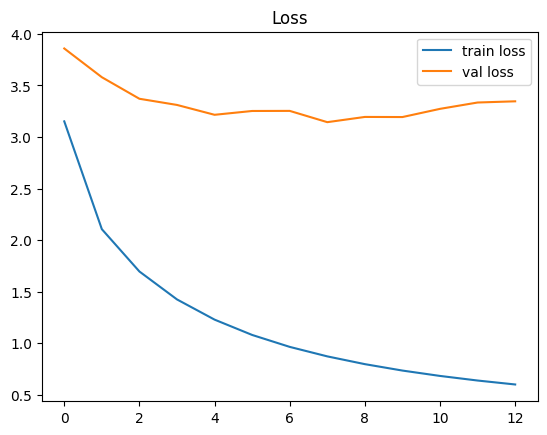

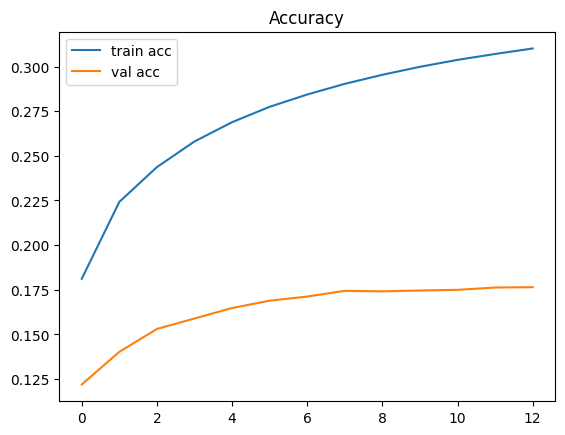

In [46]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy")
plt.show()


In [47]:
sos_id = START_TOKEN
eos_id = END_TOKEN

In [48]:
train_src = set(train_df['english_norm'])

test_df_clean = test_df[~test_df['english_norm'].isin(train_src)]


In [49]:
def batch_greedy_decode(
    model,
    sentences,
    tokenizer_en,
    tokenizer_fr,
    max_len_en,
    max_len_fr,
    sos_id,
    eos_id
):
    # Encoder input
    enc_inputs = [
        tokenizer_en.texts_to_sequences([s])[0][:max_len_en]
        for s in sentences
    ]
    enc_inputs = [
        x + [0] * (max_len_en - len(x))
        for x in enc_inputs
    ]
    enc_tensor = tf.constant(enc_inputs, dtype=tf.int32)

    batch_size = len(sentences)

    # Decoder input
    dec_inputs = tf.zeros((batch_size, max_len_fr), dtype=tf.int32)

    dec_inputs = tf.tensor_scatter_nd_update(
        dec_inputs,
        indices=[[i, 0] for i in range(batch_size)],
        updates=[sos_id] * batch_size
    )

    finished = [False] * batch_size
    outputs = [[] for _ in range(batch_size)]

    # Greedy decoding
    for t in range(1, max_len_fr):
        preds = model([enc_tensor, dec_inputs], training=False)

        next_tokens = tf.argmax(preds[:, t-1, :], axis=-1)
        next_tokens = tf.cast(next_tokens, tf.int32)

        indices = [[i, t] for i in range(batch_size)]
        dec_inputs = tf.tensor_scatter_nd_update(
            dec_inputs,
            indices,
            next_tokens
        )

        for i, tok in enumerate(next_tokens.numpy()):
            if not finished[i]:
                if tok == eos_id:
                    finished[i] = True
                else:
                    outputs[i].append(tok)

        if all(finished):
            break

    # Decode to Text
    return [
        " ".join(
            tokenizer_fr.index_word.get(t, "")
            for t in out
        ).strip()
        for out in outputs
    ]


In [50]:
from tqdm import trange

BATCH_SIZE = 32
MAX_LEN_EN = 30
MAX_LEN_FR = 30

hypotheses = []
references = []

for i in trange(0, len(test_df_clean), BATCH_SIZE):
    batch_df = test_df_clean.iloc[i:i+BATCH_SIZE]

    src_batch = batch_df["english_norm"].tolist()
    ref_batch = batch_df["french_norm"].tolist()
    preds = batch_greedy_decode(
        training_model,
        src_batch,
        tokenizer_en,
        tokenizer_fr,
        max_len_en=30,
        max_len_fr=32,
        sos_id=sos_id,
        eos_id=eos_id
    )

    hypotheses.extend(preds)
    references.extend([[r] for r in ref_batch])


100%|██████████| 315/315 [03:43<00:00,  1.41it/s]


In [51]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 10.7 MB/s eta 0:00:00


In [52]:
for i, h in enumerate(hypotheses):
    if not isinstance(h, str):
        print("NOT STRING AT INDEX:", i)
        print(type(h), h)
        break
else:
    print("ALL hypotheses ARE STRING")


ALL hypotheses ARE STRING


In [53]:
def clean_sentence_safe(x):
    if isinstance(x, list):
        x = x[0]

    return (
        x.replace("<start>", "")
         .replace("<end>", "")
         .strip()
    )


In [54]:
hypotheses_clean = []
references_clean = []

In [55]:
hypotheses_clean = [clean_sentence_safe(h) for h in hypotheses]
references_clean = [[clean_sentence_safe(r[0])] for r in references]

In [56]:
references_clean

[['je sais que je ne peux pas faire ça aussi bien que toi .'],
 ["le prisonnier s ' échappa de prison ."],
 ["c ' est mon meilleur ami . nous sommes comme des frères ."],
 ['ne bougez pas ou je tire !'],
 ["c ' est suffisamment bon ."],
 ['il va faire frais ce week end .'],
 ['les étrangers se sentent souvent de trop ici .'],
 ['tom connaît très bien cette ville .'],
 ['je vais te chercher un autre avocat .'],
 ["j ' ai lu plusieurs livres la semaine dernière ."],
 ['je ne veux pas que tu manges entre les repas .'],
 ["il dispose d ' argent ."],
 ['plus je réfléchissais à ce problème , plus il paraissait difficile .'],
 ["elle m ' est étrangère ."],
 ['sa maison est quelque part par ici .'],
 ["ne bougez pas jusqu ' à ce que je vous le dise !"],
 ["je n ' ai jamais rencontré un cas aussi étrange ."],
 ['je ne pourrais pas vivre ainsi .'],
 ['ils ont deux filles .'],
 ["qu ' est ce qui s ' est passé ici exactement hier soir ?"],
 ['où sont vos proches ?'],
 ["tu m ' as abasourdi !"],
 [

In [57]:
references_sacrebleu = [
    [r[0] for r in references_clean]
]

In [58]:
def detokenize_fr(s):
    s = s.replace(" ' ", "'")
    s = s.replace(" ,", ",")
    s = s.replace(" .", ".")
    s = s.replace(" !", "!")
    s = s.replace(" ?", "?")
    return s


In [59]:
from sacrebleu import corpus_bleu

hypotheses_detok = [detokenize_fr(h) for h in hypotheses_clean]
references_detok = [[detokenize_fr(r) for r in references_sacrebleu[0]]]

bleu = corpus_bleu(hypotheses_detok, references_detok)
print(f"BLEU score (detok): {bleu.score:.2f}")


BLEU score (detok): 22.10


In [60]:
from sacrebleu import corpus_bleu

bleu = corpus_bleu(hypotheses_clean, references_sacrebleu)

print(f"BLEU score: {bleu.score:.2f}")


BLEU score: 25.57


# Transformer

In [61]:
from tokenizers import BertWordPieceTokenizer
import os


In [62]:
tokenizer_en = BertWordPieceTokenizer(
    clean_text=True,
    lowercase=True
)

tokenizer_en.train_from_iterator(
    train_df['english_norm'].tolist(),
    vocab_size=30000,
    min_frequency=2,
    special_tokens=["[PAD]", "[UNK]", "[SOS]", "[EOS]"]
)


In [63]:
tokenizer_fr = BertWordPieceTokenizer(
    clean_text=True,
    lowercase=True
)

tokenizer_fr.train_from_iterator(
    train_df['french_norm'].tolist(),
    vocab_size=30000,
    min_frequency=2,
    special_tokens=["[PAD]", "[UNK]", "[SOS]", "[EOS]"]
)


In [64]:
MAX_LEN_EN = 40
MAX_LEN_FR = 40

def encode_en(texts):
    return [
        tokenizer_en.encode(t).ids[:MAX_LEN_EN]
        for t in texts
    ]

def encode_fr(texts):
    return [
        tokenizer_fr.encode(t).ids[:MAX_LEN_FR]
        for t in texts
    ]


In [65]:
PAD_ID = tokenizer_fr.token_to_id("[PAD]")
SOS_ID = tokenizer_fr.token_to_id("[SOS]")
EOS_ID = tokenizer_fr.token_to_id("[EOS]")


In [66]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_enc = pad_sequences(
    encode_en(train_df['english_norm']),
    maxlen=MAX_LEN_EN,
    padding="post"
)

X_train_dec_raw = [
    tokenizer_fr.encode(t).ids[:MAX_LEN_FR - 1] + [EOS_ID]
    for t in train_df["french_norm"]
]

X_train_dec = pad_sequences(
    X_train_dec_raw,
    maxlen=MAX_LEN_FR,
    padding="post",
    value=PAD_ID
)


In [67]:
X_val_enc = pad_sequences(
    encode_en(val_df['english_norm']),
    maxlen=MAX_LEN_EN,
    padding="post",
    value=PAD_ID
)

X_val_dec_raw = [
    tokenizer_fr.encode(t).ids[:MAX_LEN_FR - 1] + [EOS_ID]
    for t in val_df["french_norm"]
]

X_val_dec = pad_sequences(
    X_val_dec_raw,
    maxlen=MAX_LEN_FR,
    padding="post",
    value=PAD_ID
)

In [68]:
X_train_dec_in = np.insert(X_train_dec, 0, SOS_ID, axis=1)[:, :-1]
X_train_dec_out = X_train_dec


In [69]:
X_val_dec_in = np.insert(X_val_dec, 0, SOS_ID, axis=1)[:, :-1]
X_val_dec_out = X_val_dec



In [70]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import ops

In [71]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model, max_len):
        super().__init__()
        self.token_emb = tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=d_model,
            mask_zero=True
        )
        self.pos_emb = tf.keras.layers.Embedding(
            input_dim=max_len,
            output_dim=d_model
        )

    def call(self, x):
        positions = tf.range(start=0, limit=tf.shape(x)[1], delta=1)
        x = self.token_emb(x)
        return x + self.pos_emb(positions)


In [72]:
import tensorflow as tf
from tensorflow.keras import layers


def encoder_block(x, d_model, num_heads, ff_dim, dropout=0.1):
    # Self-Attention
    attn = layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=d_model // num_heads
    )(
        query=x,
        value=x,
        key=x
    )

    attn = layers.Dropout(dropout)(attn)
    x = layers.LayerNormalization()(x + attn)

    # Feed Forward Network
    ffn = layers.Dense(ff_dim, activation="relu")(x)
    ffn = layers.Dense(d_model)(ffn)
    ffn = layers.Dropout(dropout)(ffn)

    return layers.LayerNormalization()(x + ffn)


In [73]:
import keras
from keras import layers, ops


class CausalSelfAttention(layers.Layer):
    def __init__(self, d_model, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.mha = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=d_model // num_heads
        )

    def call(self, x):
        seq_len = ops.shape(x)[1]

        # causal mask (lower triangular)
        mask = ops.tril(
            ops.ones((seq_len, seq_len))
        )

        return self.mha(
            query=x,
            value=x,
            key=x,
            attention_mask=mask
        )


In [74]:
def decoder_block(x, enc_out, d_model, num_heads, ff_dim, dropout=0.1):
    # Masked Self-Attention
    self_attn = CausalSelfAttention(
        d_model, num_heads
    )(x)

    x = layers.LayerNormalization()(x + self_attn)

    # Cross-Attention
    cross_attn = layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=d_model // num_heads
    )(
        query=x,
        value=enc_out,
        key=enc_out
    )

    x = layers.LayerNormalization()(x + cross_attn)

    # Feed Forward
    ffn = layers.Dense(ff_dim, activation="relu")(x)
    ffn = layers.Dense(d_model)(ffn)

    return layers.LayerNormalization()(x + ffn)


In [75]:
import tensorflow as tf
from tensorflow.keras import layers


def build_transformer(
    vocab_en,
    vocab_fr,
    max_len_en,
    max_len_fr,
    d_model=256,
    num_heads=8,
    ff_dim=512,
    num_layers=2,
    dropout=0.1
):
    # Encoder
    enc_inputs = layers.Input(
        shape=(None,),
        dtype="int32",
        name="encoder_inputs"
    )

    x = PositionalEmbedding(
        vocab_en, d_model, max_len_en
    )(enc_inputs)

    x = layers.Dropout(dropout)(x)

    for _ in range(num_layers):
        x = encoder_block(
            x, d_model, num_heads, ff_dim, dropout
        )

    enc_out = x

    # Decoder
    dec_inputs = layers.Input(
        shape=(None,),
        dtype="int32",
        name="decoder_inputs"
    )

    y = PositionalEmbedding(
        vocab_fr, d_model, max_len_fr
    )(dec_inputs)

    y = layers.Dropout(dropout)(y)

    for _ in range(num_layers):
        y = decoder_block(
            y, enc_out, d_model, num_heads, ff_dim
        )

    # Output
    outputs = layers.Dense(
        vocab_fr, activation="softmax"
    )(y)

    return tf.keras.Model(
        inputs=[enc_inputs, dec_inputs],
        outputs=outputs,
        name="transformer"
    )


In [76]:
earlystop_cb = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [77]:
model = build_transformer(
    vocab_en=tokenizer_en.get_vocab_size(),
    vocab_fr=tokenizer_fr.get_vocab_size(),
    max_len_en=MAX_LEN_EN,
    max_len_fr=MAX_LEN_FR
)

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    [X_train_enc, X_train_dec_in],
    X_train_dec_out,
    validation_data=(
        [X_val_enc, X_val_dec_in],
        X_val_dec_out
    ),
    epochs=20,
    batch_size=32,
    callbacks=[earlystop_cb]
)


Epoch 1/20
4430/4430 ━━━━━━━━━━━━━━━━━━━━ 262s 47ms/step - accuracy: 0.8720 - loss: 0.8730 - val_accuracy: 0.8347 - val_loss: 1.2795
Epoch 2/20
4430/4430 ━━━━━━━━━━━━━━━━━━━━ 187s 42ms/step - accuracy: 0.9343 - loss: 0.3019 - val_accuracy: 0.8423 - val_loss: 1.3052
Epoch 3/20
4430/4430 ━━━━━━━━━━━━━━━━━━━━ 187s 42ms/step - accuracy: 0.9454 - loss: 0.2251 - val_accuracy: 0.8638 - val_loss: 1.2529
Epoch 4/20
4430/4430 ━━━━━━━━━━━━━━━━━━━━ 186s 42ms/step - accuracy: 0.9521 - loss: 0.1840 - val_accuracy: 0.8577 - val_loss: 1.2727
Epoch 5/20
4430/4430 ━━━━━━━━━━━━━━━━━━━━ 187s 42ms/step - accuracy: 0.9572 - loss: 0.1577 - val_accuracy: 0.8562 - val_loss: 1.4044
Epoch 6/20
4430/4430 ━━━━━━━━━━━━━━━━━━━━ 186s 42ms/step - accuracy: 0.9606 - loss: 0.1408 - val_accuracy: 0.8507 - val_loss: 1.8029
Epoch 7/20
4430/4430 ━━━━━━━━━━━━━━━━━━━━ 187s 42ms/step - accuracy: 0.9631 - loss: 0.1286 - val_accuracy: 0.8659 - val_loss: 1.4906
Epoch 8/20
4430/4430 ━━━━━━━━━━━━━━━━━━━━ 187s 42ms/step - accuracy: 

# Testing

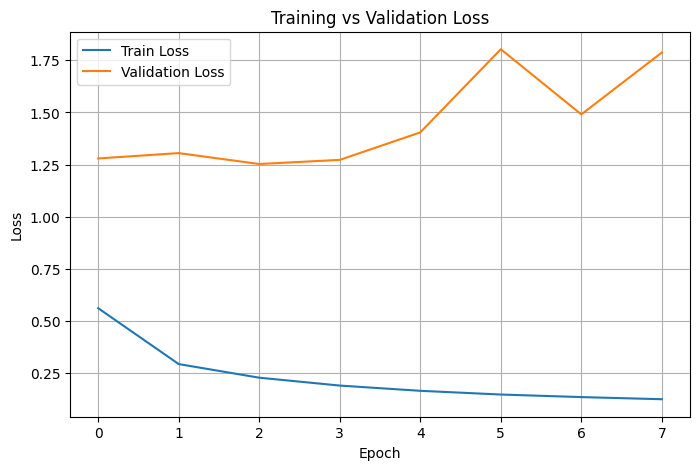

In [78]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [79]:
sos_id = tokenizer_fr.token_to_id("[SOS]")
eos_id = tokenizer_fr.token_to_id("[EOS]")


In [80]:
def batch_greedy_decode(
    model,
    sentences,
    tokenizer_en,
    tokenizer_fr,
    max_len,
    sos_id,
    eos_id
):
    enc_inputs = [
        tokenizer_en.encode(s).ids[:max_len]
        for s in sentences
    ]

    max_src_len = max(len(x) for x in enc_inputs)
    enc_inputs = [
        x + [0] * (max_src_len - len(x))
        for x in enc_inputs
    ]

    enc_tensor = tf.constant(enc_inputs, dtype=tf.int32)

    batch_size = len(sentences)
    dec_inputs = tf.constant([[sos_id]] * batch_size, dtype=tf.int32)

    finished = [False] * batch_size
    outputs = [[] for _ in range(batch_size)]

    for _ in range(max_len):
        preds = model([enc_tensor, dec_inputs], training=False)

        next_tokens = tf.argmax(preds[:, -1, :], axis=-1)
        next_tokens = tf.cast(next_tokens, tf.int32)  # 🔥 FIX

        dec_inputs = tf.concat(
            [dec_inputs, tf.expand_dims(next_tokens, 1)],
            axis=1
        )

        for i, tok in enumerate(next_tokens.numpy()):
            if not finished[i]:
                if tok == eos_id:
                    finished[i] = True
                else:
                    outputs[i].append(tok)

        if all(finished):
            break

    return [tokenizer_fr.decode(o) for o in outputs]


In [81]:
from tqdm import trange

BATCH_SIZE = 32

hypotheses = []
references = []

for i in trange(0, len(test_df), BATCH_SIZE):
    batch_df = test_df.iloc[i:i+BATCH_SIZE]

    src_batch = batch_df["english_norm"].tolist()
    ref_batch = batch_df["french_norm"].tolist()

    preds = batch_greedy_decode(
        model,
        src_batch,
        tokenizer_en,
        tokenizer_fr,
        MAX_LEN_FR,
        sos_id,
        eos_id
    )

    hypotheses.extend(preds)
    references.extend([[r] for r in ref_batch])


100%|██████████| 554/554 [23:26<00:00,  2.54s/it]


In [82]:
pip install sacrebleu

In [83]:
from sacrebleu import corpus_bleu

bleu = corpus_bleu(hypotheses, references)

print(f"BLEU score: {bleu.score:.2f}")


BLEU score: 6.74


In [84]:
from tqdm import trange

BATCH_SIZE = 32

hypotheses = []
references = []

for i in trange(0, len(test_df_clean), BATCH_SIZE):
    batch_df = test_df_clean.iloc[i:i+BATCH_SIZE]

    src_batch = batch_df["english_norm"].tolist()
    ref_batch = batch_df["french_norm"].tolist()

    preds = batch_greedy_decode(
        model,
        src_batch,
        tokenizer_en,
        tokenizer_fr,
        MAX_LEN_FR,
        sos_id,
        eos_id
    )

    hypotheses.extend(preds)
    references.extend([[r] for r in ref_batch])


100%|██████████| 315/315 [15:00<00:00,  2.86s/it]


In [85]:
from sacrebleu import corpus_bleu

bleu = corpus_bleu(hypotheses, references)

print(f"BLEU score: {bleu.score:.2f}")


BLEU score: 25.04


# Alasan BLEU score Transformer lebih rendah daripada Encoder-Decoder :

Beberapa kemungkinan:

1. Data / Training

- Transformer biasanya butuh data besar untuk outperform Encoder-Decoder klasik.

- Jika dataset relatif kecil, Encoder-Decoder bisa lebih stabil karena lebih sederhana.

2. Hyperparameter / Training

- Jumlah layer, embedding size, atau learning rate Transformer mungkin belum optimal.

- Transformer rentan overfitting atau underfitting jika tidak tuning dengan benar.

3. Nature of Metric

- BLEU hanya menghitung n-gram overlap, bukan kualitas semantik.

- Transformer bisa menghasilkan teks yang lebih “fluent / variatif” tapi skor BLEU lebih rendah karena tidak persis sama kata per kata.


Jadi, perbedaan kecil (25.05 vs 25.54) tidak selalu berarti Transformer lebih buruk, bisa karena: dataset, tokenization, atau sifat metric BLEU.

# Kesimpulan

1. BLEU score:

- Encoder-Decoder: 25.54 → sedikit lebih dekat dengan referensi

- Transformer: 25.05 → sedikit lebih variatif / kurang n-gram match

2. Interpretasi:

- Kedua model performanya mirip, perbedaan kecil (~0.5) → bisa dikatakan komparable.

- BLEU saja tidak cukup untuk menilai kualitas akhir. Analisis kualitatif seperti human evaluation untuk kualitas akhir.

- Untuk Transformer, pertimbangkan tuning hyperparameter atau dataset size agar performa optimal.

# Pretrained Transformer

In [86]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

model_name = "t5-small"  # bisa juga t5-base
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [87]:
train_texts = ["translate English to French: " + s for s in train_df['english_norm']]
train_labels = train_df['french_norm'].tolist()

val_texts = ["translate English to French: " + s for s in val_df['english_norm']]
val_labels = val_df['french_norm'].tolist()


In [88]:
max_len_input = 128
max_len_target = 128

train_encodings = tokenizer(train_texts, padding=True, truncation=True, max_length=max_len_input, return_tensors="pt")
train_labels_enc = tokenizer(train_labels, padding=True, truncation=True, max_length=max_len_target, return_tensors="pt")

val_encodings = tokenizer(val_texts, padding=True, truncation=True, max_length=max_len_input, return_tensors="pt")
val_labels_enc = tokenizer(val_labels, padding=True, truncation=True, max_length=max_len_target, return_tensors="pt")


In [89]:
import torch

class TranslationDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels['input_ids'])

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels['input_ids'][idx])
        return item

train_dataset = TranslationDataset(train_encodings, train_labels_enc)
val_dataset = TranslationDataset(val_encodings, val_labels_enc)


In [90]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./t5_mt",
    num_train_epochs=5,

    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,

    learning_rate=5e-5,
    weight_decay=0.01,

    evaluation_strategy="steps",
    eval_steps=500,
    save_steps=500,
    save_total_limit=2,

    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,

    logging_steps=100
)


TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

In [ ]:
from transformers import Trainer, EarlyStoppingCallback

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

trainer.train()



# Testing

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch

tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("./t5_mt")
model.eval()


In [ ]:
def t5_translate(sentence, model, tokenizer, max_len=128):
    text = "translate English to French: " + sentence
    inputs = tokenizer(text, return_tensors="pt", truncation=True)

    with torch.no_grad():
        outputs = model.generate(
            inputs["input_ids"],
            max_length=max_len,
            num_beams=5,
            early_stopping=True
        )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)


In [ ]:
from sacrebleu import corpus_bleu

hypotheses = []
references = []

for _, row in test_df.iterrows():
    src = row["en_norm"]
    ref = row["fr_norm"]

    pred = t5_translate(src, model, tokenizer)

    hypotheses.append(pred)
    references.append([ref])

bleu = corpus_bleu(hypotheses, references)
print("BLEU score (TEST SET):", bleu.score)
